In [1]:
from importlib import reload
import mst_mach_211028_v2 as mst

reload(mst)

import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import MDSplus as mds
import pandas as pd
import numpy as np
import numpy.linalg as nl
from scipy.optimize import curve_fit
from matplotlib.ticker import EngFormatter

import tqdm

In [2]:
time_formatter = EngFormatter('s')
current_formatter = EngFormatter('A')

In [3]:
comp='dave'
tree = 'mst'
probe_name = 'probe3_'
tips = range(1, 8)
coils = range(8, 11)
shot_null = 1210719000

mst_ops_node_paths = {"f": "\mst_ops::f", 
                      "ip": "\mst_ops::ip",
                      "btw": "\mst_ops::btw",
                      "btave": "\mst_ops::btave"}

In [4]:
shot_file = "octahedral prototype commissioning - 2021-08 - shot settings.xlsx"
compressed_shot_settings = pd.read_excel(shot_file, skiprows=2, header=0)
shot_settings = []
for i, shot in enumerate(compressed_shot_settings['Shots']): 
    if str(shot) == 'nan':
        continue
    if '-' not in shot:
        shot_settings.append(compressed_shot_settings.iloc[i].to_dict())
    if '-' in shot:
        shot_start, shot_end = shot.split('-')
        date = shot_start[:-3]
        start = shot_start[-3:]
        for j in range(int(start), int(shot_end) + 1):
            shot_to_save = date + str(j).zfill(3)
            settings = compressed_shot_settings.iloc[i].to_dict()
            settings['Shots'] = shot_to_save
            shot_settings.append(settings)
shot_settings = pd.DataFrame(shot_settings)

In [5]:
# Functions

In [6]:
def mst_ops(shot):
    server = comp + '.physics.wisc.edu'
    conn = mds.Connection(server)
    conn.openTree(tree, shot)
    ref_node_path = mst_ops_node_paths[list(mst_ops_node_paths.keys())[0]]
    ref_time = np.asarray(conn.get('DIM_OF(' + ref_node_path + ')'))
    ref_time = ref_time.astype("float64")
    ops = {}
    for key in mst_ops_node_paths.keys():
        node = conn.get(mst_ops_node_paths[key])
        data = node.data()
        time = np.asarray(conn.get('DIM_OF(' + mst_ops_node_paths[key] + ')'))
        data = data.astype("float64")
        time = time.astype("float64")
        assert np.allclose(time, ref_time), "time bases differ"
        ops[key] = data
    return ops, time

In [7]:
def build_ops_ds(shots):
    ref_data, ref_time = mst_ops(1210818038)
    ds = xr.Dataset(
                    data_vars={
                               key: (
                                     ["shot", "time"],
                                     np.array([mst_ops(shot_null + shot)[0][key] for shot in shots]),
                                    )
                                for key in ref_data.keys()
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [8]:
def shot_data(shot, node, ref_time=None):
    r'''
    '''
    server = comp + '.physics.wisc.edu'
    conn = mds.Connection(server)
    conn.openTree(tree, shot)
    signalname = '\\' + probe_name + str(node).zfill(2)
    node = conn.get(signalname)
    data = node.data()
    time = np.asarray(conn.get('DIM_OF(' + signalname + ')'))
    data = data.astype('float64')
    time = time.astype('float64')
    if not ref_time is None:
        assert np.allclose(time, ref_time), 'time not equal'
    return data, time

In [9]:
def build_b_dataset(shots):
    
    ref_data, ref_time = shot_data(1210719051, 1)  
    
    
    ds = xr.Dataset(
                    data_vars={
                               'B'+str(i+1): (
                                     ["shot", "time"],
                                     np.array([shot_data(shot_null + shot, coil, ref_time=ref_time)[0] for shot in shots]),
                                    )
                                for i, coil in enumerate(coils)
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [10]:
def build_dataset(shots):
    
    ref_data, ref_time = shot_data(1210818038, 1)  
    
    
    ds = xr.Dataset(
                    data_vars={
                               'Isat'+str(tip): (
                                     ["shot", "time"],
                                     np.array([shot_data(shot_null + shot, tip, ref_time=ref_time)[0] for shot in shots]),
                                    )
                                for tip in tips
                               },
                               coords={"time": ("time", ref_time), "shot": ("shot", shots)},
                    )
    return ds

In [11]:
def build_rj_dataset(shots):
    r"""
    Build xarray of rj values.
    """
    ds = xr.Dataset(
                    data_vars={
                               'Isat'+str(tip): (
                                    ["shot"],
                                    np.asarray([shot_settings[f'RJ{tip} (Ohm)'].iloc[[shot]].values for shot in shots])[:, 0],
                                    )
                               for tip in tips
                              },
                              coords={"shot": ("shot", shots)},        
    )
    return ds

In [12]:
def remove_offset(data, bk_start=-0.015, bk_end=-0.001):
    data = data - data.sel(time=slice(bk_start, bk_end)).mean()
    return data

In [13]:
def box_filter(data, points=50):
    box = np.ones(points)/points
    data_smooth = np.convolve(data, box, mode='same')
    return data_smooth

In [14]:
ds_B_vac = build_b_dataset(range(52, 55))
ds_ops_vac = build_ops_ds(range(52, 55))

In [15]:
ds_ops_vac

<xarray.Dataset>
Dimensions:  (shot: 3, time: 11483)
Coordinates:
  * time     (time) float64 -0.001 -0.00099 -0.00098 ... 0.1138 0.1138 0.1138
  * shot     (shot) int64 52 53 54
Data variables:
    f        (shot, time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    ip       (shot, time) float64 -0.09238 -0.09238 -0.09238 ... 0.0 0.0 0.0
    btw      (shot, time) float64 386.4 386.4 387.3 ... 0.0355 0.0355 0.0355
    btave    (shot, time) float64 384.3 384.3 384.3 384.3 ... -0.8757 0.0 0.0

In [16]:
angle = np.arcsin((ds_B_vac.B3.sel(time=slice(-0.01, 0.5), shot=54)).max()*(606)/((ds_B_vac.B1.sel(time=slice(-0.01, 0.5), shot=54)).min()*-1*833))
np.arcsin((ds_B_vac.B3.sel(time=slice(-0.01, 0.5), shot=54)).max()*(606)/((ds_B_vac.B1.sel(time=slice(-0.01, 0.5), shot=54)).min()*-1*833))/(2*np.pi)*360

<xarray.DataArray ()>
array(3.45960844)
Coordinates:
    shot     int64 54

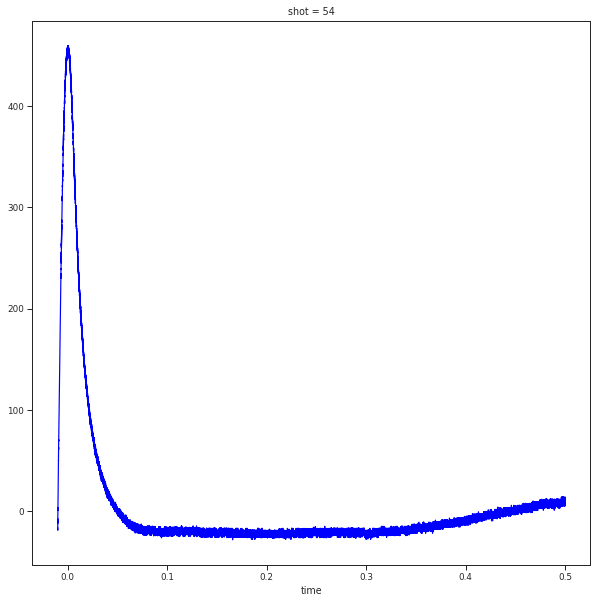

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True)
i=54
((ds_B_vac.B1.sel(time=slice(-0.01, 0.5), shot=i)*-833 + ds_B_vac.B3.sel(time=slice(-0.01, 0.5), shot=i)*-606*(0.0001/(50*3300)*10000/0.000024))).plot(ax=axes, color="blue")

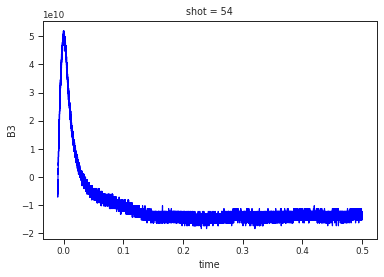

In [23]:
(ds_B_vac.B3.sel(time=slice(-0.01, 0.5), shot=i)*-833*(3300*50/0.0001*1e-5)/0.000033).plot( color="blue")


# from allyson Bt: 0.24cm^2, Bp: 0.33cm^2, Br: 1.43cm^2

RC = 0.1ms = 0.00001s
Gain = 50
conversion Tesla to Gauss 1e5

Bt factor= RC/(G*A)*conv = (0.0001)/(50*0.000024)*1e5 = 833

Bp factor = RC/(G*A)*conv = (0.0001)/(50*0.000033)*1e5 = 606


B_t = V_t*F_t - V_p * F_p * NAp_perp/NA_t

NAp_perp = RC/(3300*G)*conv

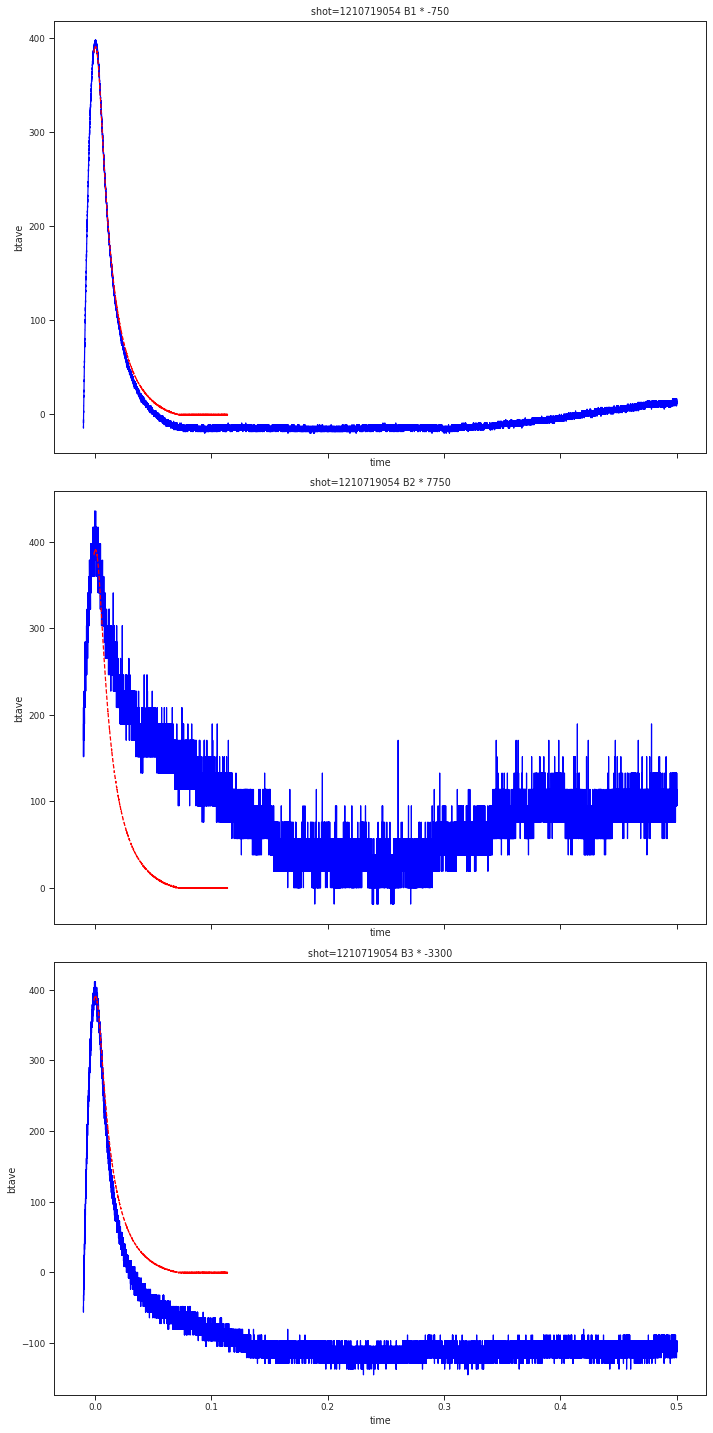

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

for i in range(54, 55):
    #(ds_ops_vac.btave.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[0], color="orange", ls=':')  
    (ds_B_vac.B1.sel(time=slice(-0.01, 0.5), shot=i)*-750).plot(ax=axes[0], color="blue")
    (ds_ops_vac.btave.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[0], color="red", ls='--')  
    
    (ds_B_vac.B2.sel(time=slice(-0.01, 0.5), shot=i)*7750).plot(ax=axes[1], color="blue")  
    (ds_ops_vac.btave.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[1], color="red", ls='--')
    (ds_B_vac.B3.sel(time=slice(-0.01, 0.5), shot=i)*-3300).plot(ax=axes[2], color="blue") 
    (ds_ops_vac.btave.sel(time=slice(-10, 0.5), shot=i)).plot(ax=axes[2], color="red", ls='--')  

axes[0].set_title("shot=1210719054 B1 * -750")
axes[1].set_title("shot=1210719054 B2 * 7750")
axes[2].set_title("shot=1210719054 B3 * -3300")

plt.tight_layout()
plt.savefig("vacuum_shot-1210719054.png")
plt.show()

In [25]:
0.1

0.1

NameError: name 'mst_ds_vac' is not defined

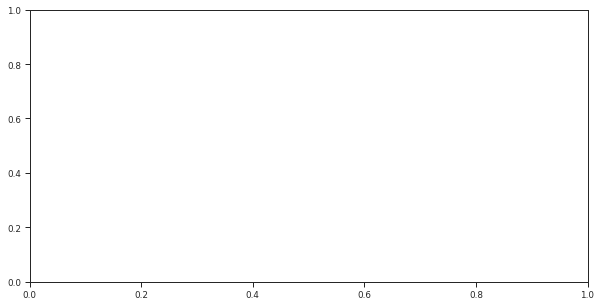

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

for i in range(1, 5):
    (mst_ds_vac.btw.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes, color="blue", alpha=0.1)    
axes.set_title("shot=1-4")


NameError: name 'mst_ds_vac' is not defined

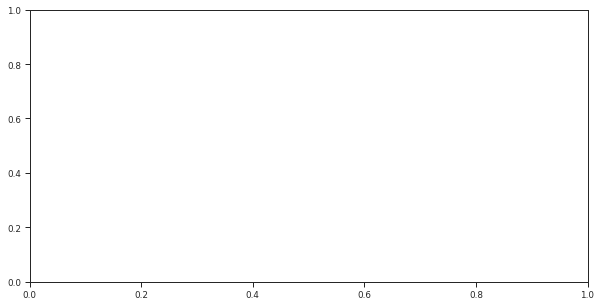

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

for i in range(1, 5):
    (mst_ds_vac.btave.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes, color="blue", alpha=0.1)    
axes.set_title("shots=1-4")


NameError: name 'mst_ds_vac' is not defined

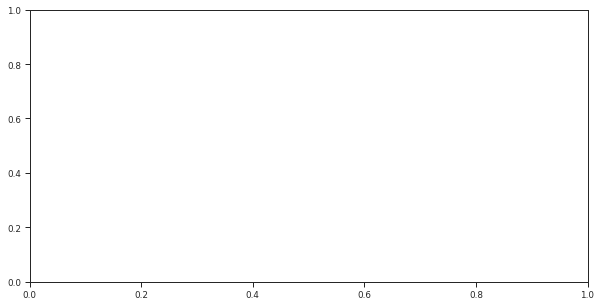

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

for i in range(1, 5):
    (mst_ds_vac.ip.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes, color="blue", alpha=0.1)    
axes.set_title("shots=1-4")
plt.show()

NameError: name 'mst_ds_vac' is not defined

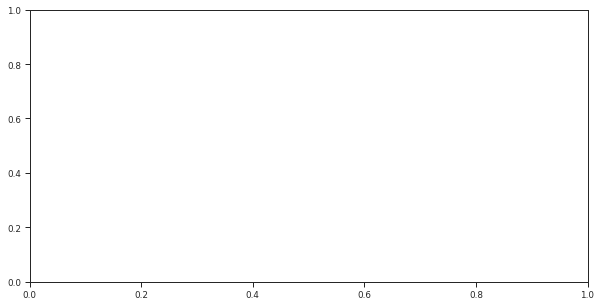

In [20]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

for i in range(1, 4):
    (mst_ds_vac.btw.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes, color="blue", alpha=0.1)    
axes.set_title("shot=1-3")

NameError: name 'mst_ds_vac' is not defined

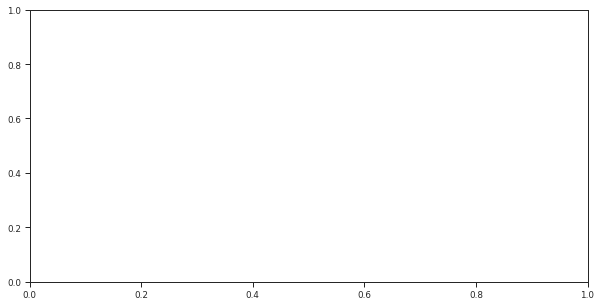

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

for i in range(1, 4):
    (mst_ds_vac.btave.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes, color="blue", alpha=0.1)    
axes.set_title("shot=1-3")

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

for i in range(1, 11):
    (mst_ds_vac.ip.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes, color="blue", alpha=0.1)    
axes.set_title("shots=4-10")
plt.show()

NameError: name 'plt' is not defined

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10,5), sharex=True)

for i in range(4, 11):
    (mst_ds_vac.btw.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes, color="blue", alpha=0.1)    
axes.set_title("shots=4-10")
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

for i in range(2, 3):
    (ds_B_vac.B1.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes[0], color="blue")  
    (ds_B_vac.B2.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes[1], color="blue")  
    (ds_B_vac.B3.sel(time=slice(-0.01, 0.5), shot=i)).plot(ax=axes[2], color="blue")  
axes[0].set_title("shot=10")
axes[1].set_title("")
axes[2].set_title("")

plt.tight_layout()
plt.savefig("vacuum_shot.png")
plt.show()

In [ ]:
ds_B_cond = build_b_dataset(range(11, 14))

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

for i in range(11, 12):
    (ds_B_cond.B1.sel(time=slice(-0.01, 0.05), shot=i)*-1).plot(ax=axes[0], color="blue")  
    (ds_B_cond.B2.sel(time=slice(-0.01, 0.05), shot=i)).plot(ax=axes[1], color="blue")  
    (ds_B_cond.B3.sel(time=slice(-0.01, 0.05), shot=i)*-1).plot(ax=axes[2], color="blue")  
axes[0].set_title("shot=11, conditioning")
axes[1].set_title("")
axes[2].set_title("")

plt.tight_layout()
plt.show()

In [ ]:
ds_B = build_b_dataset(range(11, 40))

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20), sharex=True)

for i in range(15, 39):
    (ds_B.B1.sel(time=slice(-0.01, 0.07), shot=i)*-1).plot(ax=axes[0], color="blue", alpha=0.1)  
    (ds_B.B2.sel(time=slice(-0.01, 0.07), shot=i)).plot(ax=axes[1], color="blue", alpha=0.1)  
    (ds_B.B3.sel(time=slice(-0.01, 0.07), shot=i)*-1).plot(ax=axes[2], color="blue", alpha=0.1)  
axes[0].set_title("shots=30-39")
axes[1].set_title("")
axes[2].set_title("")

plt.tight_layout()
plt.show()

In [ ]:
ds_B_r_10 = build_b_dataset(range(62, 80))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

for i in range(31, 39):    
    (ds_B.B1.sel(time=slice(-0.01, 0.07), shot=i)*-1).plot(ax=axes, color="red", alpha=0.1, label="r/a=0.90") 

plt.title("shots=31-38")
plt.tight_layout()
plt.savefig("output/B_tor_at_r09.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

for i in range(62, 64):
    (ds_B_r_10.B1.sel(time=slice(-0.01, 0.07), shot=i)*-1).plot(ax=axes, color="blue", alpha=0.1, label="r/a=0.81") 

plt.title("shots=62-63")
plt.tight_layout()
plt.savefig("output/B_tor_at_r081.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5), sharex=True)

(ds_B_r_10.B1.sel(time=slice(-0.02, 0.07), shot=slice(62,63)).mean(dim="shot")*-1).plot(ax=axes, color="blue", label="r/a=0.81") 
   
(ds_B.B1.sel(time=slice(-0.02, 0.07), shot=slice(31, 39)).mean(dim="shot")*-1).plot(ax=axes, color="red", label="r/a=0.90") 
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("output/B_tor.png")
plt.show()

# Need to check density

In [34]:
ds_coil = build_b_dataset(range(11, 50))